In [1]:
import msprime
import numpy as np
import tskit

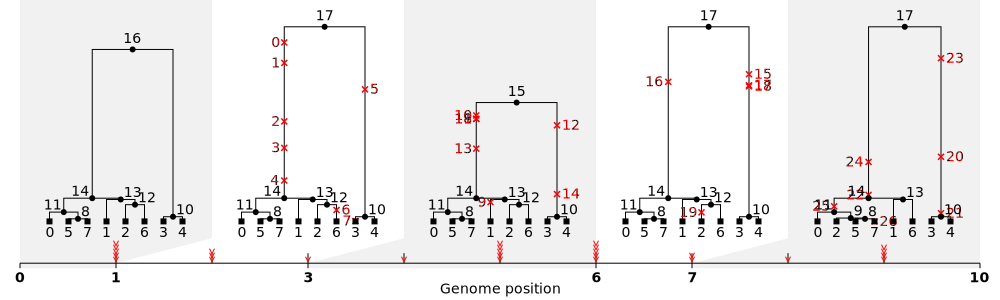

In [2]:
ts = msprime.sim_ancestry(samples=4, recombination_rate=0.2, sequence_length=10, random_seed=1)
ts = msprime.sim_mutations(ts, rate=.5, random_seed=1)
ts.draw_svg(size=(1000, 300))

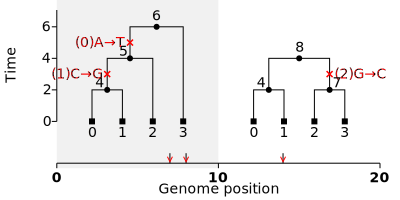

In [3]:
import tskit
import io

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
0         2
0         4
0         6
0         2
0         4
"""

edges = """\
left right parent child
0    10    4      0,1
0    10    5      2,4
0    10    6      3,5
10   20    4      0,1
10   20    7      2,3
10   20    8      4,7
"""

sites = """\
position ancestral_state
7        A
8        C
14       G
"""

# this is what's on disk
mutations = """\
site node parent derived_state
0    5    -1     T
1    4    -1     G
2    7    -1     C
# """
# mutations = """\
# site node parent derived_state
# 0    5    -1     T
# 1    4    -1     G
# 2    4    -1     C
# """

# mutations = """\
# site node parent derived_state
# 0    5    -1     T
# 0    4    0      G
# 1    4    -1     G
# 2    4    -1     C
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    sites=io.StringIO(sites),
    mutations=io.StringIO(mutations),
    strict=False,
)

mut_labels = {}  # An array of labels for the mutations
for mut in ts.mutations():  # Make pretty labels showing the change in state
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"({mut.site}){prev}→{mut.derived_state}"

ts.draw_svg(
    y_axis=True,
    mutation_labels=mut_labels
)

In [4]:
# ts.dump('../tree-simple.tree')

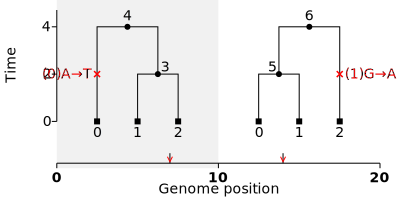

In [119]:
import tskit
import io

nodes = """\
is_sample time
1         0
1         0
1         0
0         2
0         4
0         2
0         4
"""

edges = """\
left right parent child
0    10    4      0,3
0    10    3      1,2
10   20    5      0,1
10   20    6      2,5
"""

sites = """\
position ancestral_state
7        A
14       G
"""

mutations = """\
site node parent derived_state
0    0    -1     T
1    2    -1     A
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    sites=io.StringIO(sites),
    mutations=io.StringIO(mutations),
    strict=False,
)

mut_labels = {}  # An array of labels for the mutations
for mut in ts.mutations():  # Make pretty labels showing the change in state
    site = ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"({mut.site}){prev}→{mut.derived_state}"

ts.draw_svg(
    y_axis=True,
    mutation_labels=mut_labels
)

In [121]:
# ts.dump('../tree-simple-1.tree')

In [122]:
# ts.diversity(span_normalise=False, sample_sets=[[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]])

In [123]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
sample_sets = [[0, 1, 2]]

tj = 0
tk = 0
t_left = 0
tree_iter = enumerate(ts.trees())
tree_index, tree = next(tree_iter)
window_index = 0
I = ts.indexes_edge_insertion_order
O = ts.indexes_edge_removal_order
parent = -np.ones(ts.num_nodes, dtype=np.int32)

state = np.zeros((ts.num_nodes, len(sample_sets)), dtype=np.int32)
allele_state = []

for i, sample_set in enumerate(sample_sets):
    state[sample_set, i] = 1

while (tj < ts.num_edges) or (t_left < ts.sequence_length):
    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        while (v != -1):
            state[v] += -state[u]
            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            state[v] += state[u]
            v = parent[v]
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])

    for site in tree.sites():
        allele_mat = np.zeros((len(site.mutations) + 1, len(sample_sets)))
        allele_states = [site.ancestral_state]
        allele = 0
        allele_mat[allele] = np.array(list(map(len, sample_sets)))
        for mutation in site.mutations:

            if mutation.derived_state in allele_states:
                allele = allele_states.index(mutation.derived_state)
            else:
                allele_states.append(mutation.derived_state)
                allele = len(allele_states) - 1
            allele_mat[allele] += state[mutation.node]

            alt_allele = allele_states.index(site.ancestral_state)
            if mutation.parent != -1:
                # TODO haven't exercised this code path yet
                alt_allele = allele_states.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
            allele_mat[alt_allele] -= state[mutation.node]

        allele_state.append((len(allele_states), allele_mat))

    try:
        tree_index, tree = next(tree_iter)
    except StopIteration:
        tree_index += 1

    t_left = t_right

for _n_alleles, _a_state in allele_state:
    print(_a_state)

[[2.]
 [1.]]
[[2.]
 [1.]]


In [124]:
ts.indexes_edge_insertion_order

array([0, 1, 4, 5, 2, 3, 6, 7], dtype=int32)

In [125]:
ts.indexes_edge_removal_order

array([5, 4, 1, 0, 7, 6, 3, 2], dtype=int32)

In [126]:
list(ts.at_index(0).nodes(order='postorder'))

[0, 1, 2, 3, 4]

In [127]:
list(ts.at_index(0).nodes(order='preorder'))

[4, 0, 3, 1, 2]

In [128]:
list(ts.at_index(0).nodes(order='inorder'))

[0, 4, 1, 3, 2]

In [129]:
def diversity_summary_func(state, sample_sets):
    x = state
    n = np.array([len(ss) for ss in sample_sets])  # sample_set_sizes
    return x * (n - x) / (n * (n - 1))

In [130]:
stats = []
for _n_alleles, _a_state in allele_state:
    for i in range(_n_alleles):  # If polarized, range from 1
        stats.append(diversity_summary_func(_a_state[i], sample_sets))

In [131]:
_a_state[i]

array([1.])

In [132]:
_a_state

array([[2.],
       [1.]])

In [133]:
np.vstack(stats).sum(0)

array([1.33333333])

In [134]:
ts.diversity(span_normalise=False)

array(1.33333333)

In [135]:
from IPython import display

[1]


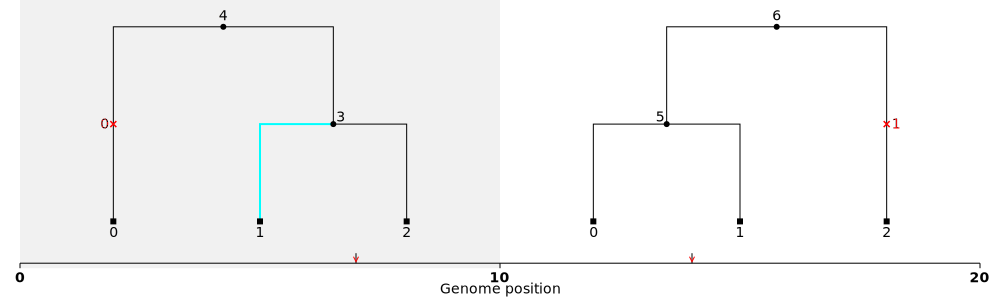

[1]


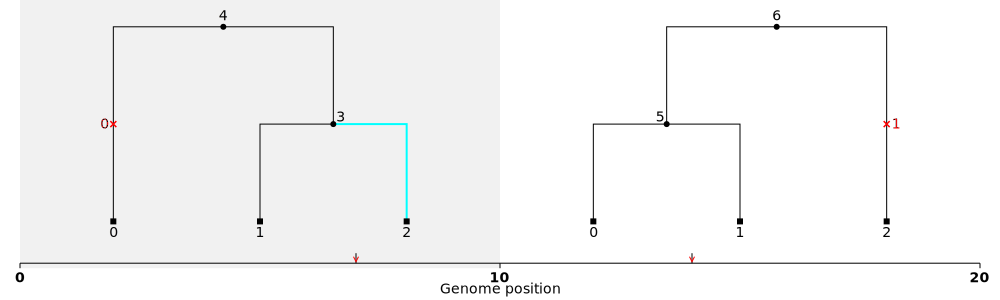

[1]


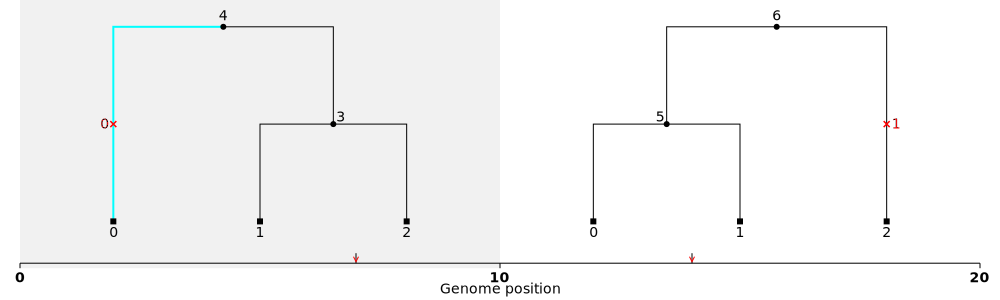

[2]


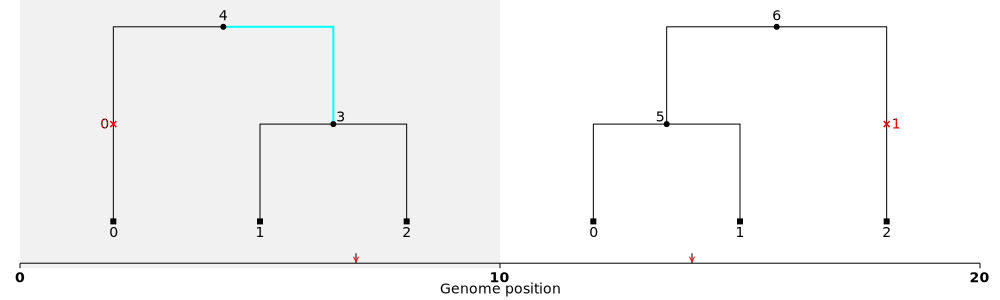

In [300]:
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]
sample_sets = [[0, 1, 2]]

tj = 0
tk = 0
t_left = 0
tree_iter = enumerate(ts.trees())
tree_index, tree = next(tree_iter)
window_index = 0
I = ts.indexes_edge_insertion_order
O = ts.indexes_edge_removal_order
parent = -np.ones(ts.num_nodes, dtype=np.int32)

left_child = -np.ones(ts.num_nodes, dtype=np.int32)
right_child = -np.ones(ts.num_nodes, dtype=np.int32)
left_sib = -np.ones(ts.num_nodes, dtype=np.int32)
right_sib = -np.ones(ts.num_nodes, dtype=np.int32)

states = []
state = np.zeros((ts.num_nodes, len(sample_sets)), dtype=np.int32)
allele_state = []

for i, sample_set in enumerate(sample_sets):
    state[sample_set, i] = 1


while (tj < ts.num_edges) or (t_left < ts.sequence_length):
    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]

        while (v != -1):
            print(state[u])
            display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: red; stroke-width: 2px}}'))
            state[v] += -state[u]
            
            if left_sib[u] == -1:
                left_child[v] = right_sib[u]
            else:
                right_sib[left_sib[u]] = right_sib[u]
            if right_sib[u] == -1:
                right_child[v] = left_sib[u]
            else:
                left_sib[right_sib[u]] = left_sib[u]
            left_sib[u] = -1
            right_sib[u] = -1

            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            print(state[u])
            display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            state[v] += state[u]
            
            c = right_child[v]
            if c == -1:
                left_child[v] = u
                left_sib[u] = -1
                right_sib[u] = -1
            else:
                right_sib[c] = u
                left_sib[u] = c
                right_sib[u] = -1

            right_child[v] = u

            v = parent[v] 
            
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])
    break
    for site in tree.sites():
        allele_mat = np.zeros((len(site.mutations) + 1, len(sample_sets)))
        allele_states = [site.ancestral_state]
        allele = 0
        allele_mat[allele] = np.array(list(map(len, sample_sets)))
        for mutation in site.mutations:

            if mutation.derived_state in allele_states:
                allele = allele_states.index(mutation.derived_state)
            else:
                allele_states.append(mutation.derived_state)
                allele = len(allele_states) - 1
            allele_mat[allele] += state[mutation.node]

            alt_allele = allele_states.index(site.ancestral_state)
            if mutation.parent != -1:
                # TODO haven't exercised this code path yet
                alt_allele = allele_states.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
            allele_mat[alt_allele] -= state[mutation.node]

        allele_state.append((len(allele_states), allele_mat))

    states.append(state.copy())
    try:
        tree_index, tree = next(tree_iter)
    except StopIteration:
        tree_index += 1

    t_left = t_right

# for _n_alleles, _a_state in allele_state:
#     print(_a_state)

In [301]:
print(right_sib, ts.at_index(0).right_sib_array, sep='\n')

[ 3  2 -1 -1 -1 -1 -1]
[ 3  2 -1 -1 -1 -1 -1 -1]


In [302]:
print(left_sib, ts.at_index(0).left_sib_array, sep='\n')

[-1 -1  1  0 -1 -1 -1]
[-1 -1  1  0 -1 -1 -1 -1]


In [303]:
print(left_child, ts.at_index(0).left_child_array, sep='\n')

[-1 -1 -1  1  0 -1 -1]
[-1 -1 -1  1  0 -1 -1  4]


In [304]:
print(right_child, ts.at_index(0).right_child_array, sep='\n')

[-1 -1 -1  2  3 -1 -1]
[-1 -1 -1  2  3 -1 -1  4]


In [137]:
states

[array([[1],
        [1],
        [1],
        [2],
        [3],
        [0],
        [0]], dtype=int32),
 array([[1],
        [1],
        [1],
        [0],
        [0],
        [2],
        [3]], dtype=int32)]

In [138]:
list(ts.at_index(0).nodes(5, order='postorder'))

[5]

In [139]:
list(ts.at_index(0).nodes(-1, order='postorder'))

[0, 1, 2, 3, 4]

In [258]:
I = ts.indexes_edge_insertion_order
O = ts.indexes_edge_removal_order

num_tracked_samples = [0, 0, 0, 0, 0, 0, 0]
node = 0
# node = 5
nodes = list(ts.at_index(0).nodes(node, order='postorder'))
for j in range(len(nodes)):
    u = nodes[j]
    v = ts.at_index(0).left_child(u)
    while v != -1:
        num_tracked_samples[u] += num_tracked_samples[v]
        v = ts.at_index(0).right_sib(u)
    num_tracked_samples[u] += 1 if (ts.node(u).flags & 1) else 0
    n = num_tracked_samples[u]
    u = ts.at_index(0).parent(u)
    while u != -1:
        num_tracked_samples[u] = n
        u = ts.at_index(0).parent(u)

print(num_tracked_samples)

out = 0  # TODO What is out in this context? (see tsk_tree_advance out_index)
i = 4  # TODO What is in in this context? (see tsk_tree_advance in_index)
while out < ts.num_edges and ts.edges_right[O[out]] == ts.at_index(0).interval.right:
    k = O[out]
    out += 1
    # NB redefine u here
    u = ts.edges_parent[k]
    c = ts.edges_child[k]
    while u != -1:
        num_tracked_samples[u] -= num_tracked_samples[c]
        print(f'removed {u} {c}', end=' ')
        u = ts.at_index(0).parent(u)
        # u = parent[u]
    print()
while i < ts.num_edges and ts.edges_left[I[i]] == ts.at_index(0).interval.right:
    k = I[i]
    i += 1
    u = ts.edges_parent[k]
    c = ts.edges_child[k]
    while u != -1:
        num_tracked_samples[u] += num_tracked_samples[c]
        print(f'added {u} {c}', end=' ')
        u = ts.at_index(0).parent(u)
        # u = parent[u]
    print()


# out = 0  # TODO What is out in this context? (see tsk_tree_advance out_index)
# i = 4  # TODO What is in in this context? (see tsk_tree_advance in_index)
# while out < ts.num_edges and ts.edges_right[O[out]] == ts.at_index(0).interval.right:
#     k = O[out]
#     out += 1
#     # NB redefine u here
#     u = ts.edges_parent[k]
#     c = ts.edges_child[k]
#     num_tracked_samples[u] -= num_tracked_samples[c]
#     print(f'removed {k} {u} {c}')
# while i < ts.num_edges and ts.edges_left[I[i]] == ts.at_index(0).interval.right:
#     k = I[i]
#     i += 1
#     u = ts.edges_parent[k]
#     c = ts.edges_child[k]
#     num_tracked_samples[u] += num_tracked_samples[c]
#     print(f'added {k} {u} {c}')

print(num_tracked_samples)

[1, 0, 0, 0, 1, 0, 0]
removed 4 3 
removed 4 0 
removed 3 2 removed 4 2 
removed 3 1 removed 4 1 
added 5 0 
added 5 1 
added 6 2 
added 6 5 
[1, 0, 0, 0, 0, 1, 1]


In [147]:
O

array([5, 4, 1, 0, 7, 6, 3, 2], dtype=int32)

In [148]:
I

array([0, 1, 4, 5, 2, 3, 6, 7], dtype=int32)

In [151]:
states[0]

array([[1],
       [1],
       [1],
       [2],
       [3],
       [0],
       [0]], dtype=int32)

In [157]:
ts.edges_parent

array([3, 3, 5, 5, 4, 4, 6, 6], dtype=int32)

In [347]:
I = ts.indexes_edge_insertion_order
O = ts.indexes_edge_removal_order

mut_parent = ts.edge(ts.mutation(0).edge).parent
if ts.edges_parent[mut_parent - 1] == mut_parent:
    prune_edge = mut_parent - 1
elif ts.edges_parent[mut_parent + 1] == mut_parent:
    prune_edge = mut_parent + 1
else:
    raise Exception('Unexpected condition')

# start_state = states[0].copy()
start_state = state.copy()
start_state[ts.edge(prune_edge).parent] -= start_state[ts.edge(prune_edge).child]

# last_p = ts.edges_parent[prune_edge]
# while True:
#     c = ts.edges_child[prune_edge]
#     p = ts.edges_parent[prune_edge]
#     if p > last_p:
#         break
#     start_state[c] -= start_state[c]

stack = []
stack.append(ts.edge(prune_edge).child)
while len(stack) > 0:
    node = stack.pop()
    start_state[node] -= start_state[node]
    if right_child[node] != -1:
        stack.append(right_child[node])
    if left_child[node] != -1:
        stack.append(left_child[node])

out = 0  # TODO What is out in this context? (see tsk_tree_advance out_index)
i = 4  # TODO What is in in this context? (see tsk_tree_advance in_index)
while out < ts.num_edges and ts.edges_right[O[out]] == ts.at_index(0).interval.right:
    k = O[out]
    out += 1
    # NB redefine u here
    u = ts.edges_parent[k]
    c = ts.edges_child[k]
    start_state[u] -= start_state[c]
    print(f'removed {k} {u} {c}')
while i < ts.num_edges and ts.edges_left[I[i]] == ts.at_index(0).interval.right:
    k = I[i]
    i += 1
    u = ts.edges_parent[k]
    c = ts.edges_child[k]
    start_state[u] += start_state[c]
    print(f'added {k} {u} {c}')

removed 5 4 3
removed 4 4 0
removed 1 3 2
removed 0 3 1
added 2 5 0
added 3 5 1
added 6 6 2
added 7 6 5


In [348]:
start_state

array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [349]:
print(right_sib, ts.at_index(0).right_sib_array, sep='\n')

[ 3  2 -1 -1 -1 -1 -1]
[ 3  2 -1 -1 -1 -1 -1 -1]


In [350]:
print(left_sib, ts.at_index(0).left_sib_array, sep='\n')

[-1 -1  1  0 -1 -1 -1]
[-1 -1  1  0 -1 -1 -1 -1]


In [351]:
print(left_child, ts.at_index(0).left_child_array, sep='\n')

[-1 -1 -1  1  0 -1 -1]
[-1 -1 -1  1  0 -1 -1  4]


In [352]:
print(right_child, ts.at_index(0).right_child_array, sep='\n')

[-1 -1 -1  2  3 -1 -1]
[-1 -1 -1  2  3 -1 -1  4]


In [247]:
parent

array([ 4,  3,  3,  4, -1, -1, -1], dtype=int32)

In [241]:
I

array([0, 1, 4, 5, 2, 3, 6, 7], dtype=int32)

In [242]:
O

array([5, 4, 1, 0, 7, 6, 3, 2], dtype=int32)

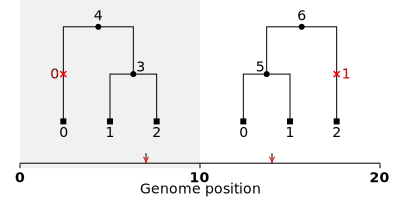

In [243]:
ts.draw_svg()

In [240]:
ts.edges_child[prune_edge]

3

In [250]:
v = parent[ts.edges_child[prune_edge]]
while v != -1:
    print(v)
    v = parent[v]

4


In [251]:
parent

array([ 4,  3,  3,  4, -1, -1, -1], dtype=int32)

In [255]:
ts.at_index(0).left_child_array

array([-1, -1, -1,  1,  0, -1, -1,  4], dtype=int32)

In [214]:
ts.tables.edges

id,left,right,parent,child,metadata
0,0,10,3,1,
1,0,10,3,2,
2,10,20,5,0,
3,10,20,5,1,
4,0,10,4,0,
5,0,10,4,3,
6,10,20,6,2,
7,10,20,6,5,


In [207]:
ts.edges_child

array([1, 2, 0, 1, 0, 3, 2, 5], dtype=int32)

In [203]:
start_state

array([[1],
       [1],
       [1],
       [2],
       [1],
       [0],
       [0]], dtype=int32)

In [212]:
parent

array([ 4,  3,  3,  4, -1, -1, -1], dtype=int32)

In [200]:
start_state

array([[1],
       [1],
       [1],
       [2],
       [1],
       [0],
       [0]], dtype=int32)

In [211]:
states

[array([[1],
        [1],
        [1],
        [2],
        [3],
        [0],
        [0]], dtype=int32),
 array([[1],
        [1],
        [1],
        [0],
        [0],
        [2],
        [3]], dtype=int32)]

In [186]:
prune_edge

5

In [184]:
print(edges)

left right parent child
0    10    4      0,3
0    10    3      1,2
10   20    5      0,1
10   20    6      2,5



In [171]:
ts.edge(ts.mutation(0).edge).parent

4

In [172]:
ts.edges_parent

array([3, 3, 5, 5, 4, 4, 6, 6], dtype=int32)

In [173]:
ts.tables.edges

id,left,right,parent,child,metadata
0,0,10,3,1,
1,0,10,3,2,
2,10,20,5,0,
3,10,20,5,1,
4,0,10,4,0,
5,0,10,4,3,
6,10,20,6,2,
7,10,20,6,5,


In [174]:
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,-1,-1,0,
1,1,-1,-1,0,
2,1,-1,-1,0,
3,0,-1,-1,2,
4,0,-1,-1,4,
5,0,-1,-1,2,
6,0,-1,-1,4,
